In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Parametric PINN: inputs [x, n]
class ParametricPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,128), nn.Tanh(),
            nn.Linear(128,64), nn.Tanh(),
            nn.Linear(64,32),  nn.Tanh(),
            nn.Linear(32,8),   nn.Tanh(),
            nn.Linear(8,1)
        )
    def forward(self, x, n):
        # x, n are both [batch,1] tensors
        inp = torch.cat([x, n], dim=1)   # → [batch,2]
        return self.net(inp)             # → [batch,1]

model = ParametricPINN().to(device)

# 3. Hyperparameters
L, m, hbar = 1.0, 1.0, 1.0
N_f   = 1000   # collocation points per n
N_norm= 1000    # normalization grid points per n
epochs= 30000
n_values = [1.0,2.0,3.0,4.0,5.0]

# 4. Precompute static tensors
x_b = torch.tensor([[0.0],[L]], device=device)      # boundary x
x_norm_grid = torch.linspace(0, L, N_norm, device=device).view(-1,1)

# 5. Physics residual for a given n_val
def physics_residual(x, n_val):
    x = x.requires_grad_(True)
    psi = model(x, torch.full_like(x, n_val))
    psi_x = torch.autograd.grad(psi, x,
                grad_outputs=torch.ones_like(psi),
                create_graph=True)[0]
    psi_xx= torch.autograd.grad(psi_x, x,
                grad_outputs=torch.ones_like(psi_x),
                create_graph=True)[0]
    return psi_xx + (n_val*np.pi)**2 * psi

# 6. Weight scheduling (piecewise)
def get_weights(epoch):
    if epoch < 2500:
        return 5.0, 1.0, 3.0, 1.0
    else:
        return 4.0, 5.0, 1.2, 10.0

# 7. Single-epoch loss accumulation over n=1..5
def compute_loss(epoch):
    λ_pde, λ_bc, λ_triv, λ_norm = get_weights(epoch)
    total_loss = 0.0

    for n_val in n_values:
        # 7.1 PDE residual loss
        x_f = torch.rand(N_f,1, device=device) * L
        res = physics_residual(x_f, n_val)
        loss_pde = torch.mean(res**2)

        # 7.2 Boundary loss at x=0 and x=L
        n_b = torch.tensor([[n_val],[n_val]], device=device)
        psi_b = model(x_b, n_b)
        loss_bc = torch.mean(psi_b**2)

        # 7.3 Normalization loss via trapezoidal rule
        n_norm = torch.full((N_norm,1), n_val, device=device)
        psi_n  = model(x_norm_grid, n_norm).squeeze()
        integral = torch.trapz(psi_n**2, x_norm_grid.squeeze())
        loss_norm = (integral - 1.0)**2

        # 7.4 Trivial‐solution penalty (inverse mean abs)
        m_abs = torch.mean(torch.abs(psi_n))
        loss_triv = λ_triv / (m_abs + 1e-6)**2

        # 7.5 accumulate
        total_loss += (
              λ_pde  * loss_pde
            + λ_bc   * loss_bc
            + λ_norm * loss_norm
            + loss_triv
        )
    return total_loss / len(n_values)



In [23]:
# 8. Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    loss = compute_loss(epoch)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Loss = {loss.item():.3e}")

Epoch   500 | Loss = 8.678e+02
Epoch  1000 | Loss = 8.521e+02
Epoch  1500 | Loss = 8.481e+02
Epoch  2000 | Loss = 8.461e+02
Epoch  2500 | Loss = 5.151e+02
Epoch  3000 | Loss = 4.863e+02
Epoch  3500 | Loss = 4.863e+02
Epoch  4000 | Loss = 4.860e+02
Epoch  4500 | Loss = 4.857e+02
Epoch  5000 | Loss = 4.856e+02
Epoch  5500 | Loss = 4.853e+02
Epoch  6000 | Loss = 4.851e+02
Epoch  6500 | Loss = 4.848e+02
Epoch  7000 | Loss = 4.843e+02
Epoch  7500 | Loss = 4.837e+02
Epoch  8000 | Loss = 4.822e+02
Epoch  8500 | Loss = 4.812e+02
Epoch  9000 | Loss = 4.769e+02
Epoch  9500 | Loss = 4.735e+02
Epoch 10000 | Loss = 4.684e+02
Epoch 10500 | Loss = 4.670e+02
Epoch 11000 | Loss = 4.612e+02
Epoch 11500 | Loss = 4.594e+02
Epoch 12000 | Loss = 4.319e+02
Epoch 12500 | Loss = 2.200e+02
Epoch 13000 | Loss = 1.320e+02
Epoch 13500 | Loss = 1.614e+02
Epoch 14000 | Loss = 9.962e+01
Epoch 14500 | Loss = 8.193e+01
Epoch 15000 | Loss = 1.018e+02
Epoch 15500 | Loss = 7.619e+01
Epoch 16000 | Loss = 5.681e+01
Epoch 16

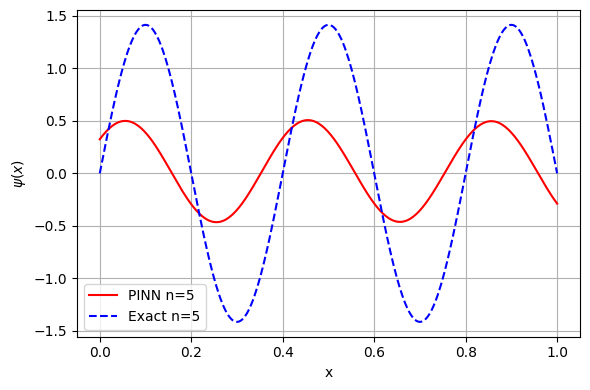

In [28]:

# 9. Inference & Plotting helper
def plot_solution(n_val):
    x_plot = np.linspace(0, L, 300).reshape(-1,1)
    x_torch= torch.tensor(x_plot, dtype=torch.float32, device=device)
    n_torch= torch.full_like(x_torch, float(n_val), device=device)

    psi_pred = model(x_torch, n_torch).detach().cpu().numpy().flatten()
    psi_exact= np.sqrt(2/L) * np.sin(n_val * np.pi * x_plot.flatten() / L)

    plt.figure(figsize=(6,4))
    plt.plot(x_plot, psi_pred, 'r-', label=f'PINN n={n_val}')
    plt.plot(x_plot, psi_exact,'b--',label=f'Exact n={n_val}')
    plt.xlabel('x'); plt.ylabel(r'$\psi(x)$')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

plot_solution(3)
